# Homework 5
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and HAC methods for clustering.

这份作业包含的主题：用于聚类的K-means 和 HAC（层次凝聚聚类）方法。

In [20]:
# Setup
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering and Hierarchical Agglomerative Clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.
- **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

使用聚类算法实现图像分割，分割图像前景和背景。

作业分为这三步：
1. 聚类算法的实现：实现K-Means聚类和层次凝聚聚类
2. 像素级特征：实现结合颜色和位置信息的特征向量以及实现特征归一化。
3. 量化评估：通过将计算出来的分割结果与GroundTruth进行比较，评估具有各种参数设置的分割算法。

**量化评估这一块重要，我还没学过评估分割结果的方法**

## 1 Clustering Algorithms (40 points)

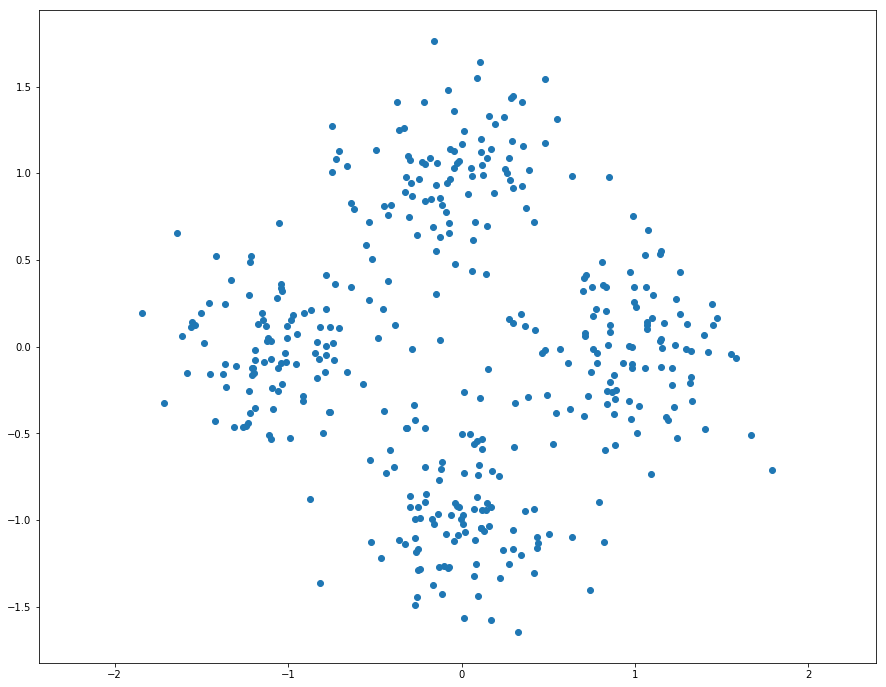

In [21]:
# Generate random data points for clustering

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (20 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute new mean of each cluster.

>**K-Means Wiki**
>
>[k-平均算法](https://zh.wikipedia.org/wiki/K-%E5%B9%B3%E5%9D%87%E7%AE%97%E6%B3%95)

目前题图允许使用循环实现点到最近中心的分配即可。

K-means的步骤：
1. 随机初始化聚类中心
2. 将点分配给最近的中心
3. 计算每个聚类的新的中心
4. 如果聚类的分配不再变动则停止
5. 从第二步继续循环

迭代次数 8
kmeans running time: 0.061108 seconds.


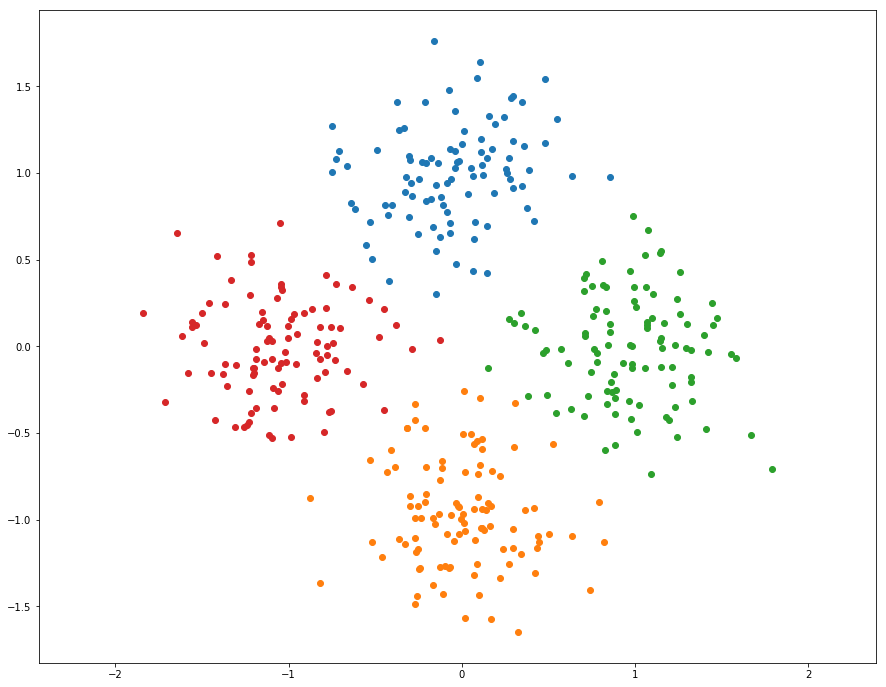

In [22]:
from segmentation import kmeans

np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

**哈，简单的实现了K-Means算法，发现第三步判断终止条件很重要，添加了以后只迭代了几次就结束了，大大降低了运行时间。**

We can use numpy functions and broadcasting to make kmeans faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run at least 10 times faster than the previous implementation.

又是加快运算速度的老要求。

想想思路：

- 题目的提示是使用numpy函数和broadcasting机制
- np.repeat and np.argmin 有帮助
- 还有一种思路就是向量化了，不做迭代而是放在矩阵里去计算。

kmeans running time: 0.003889 seconds.
15.714531 times faster!


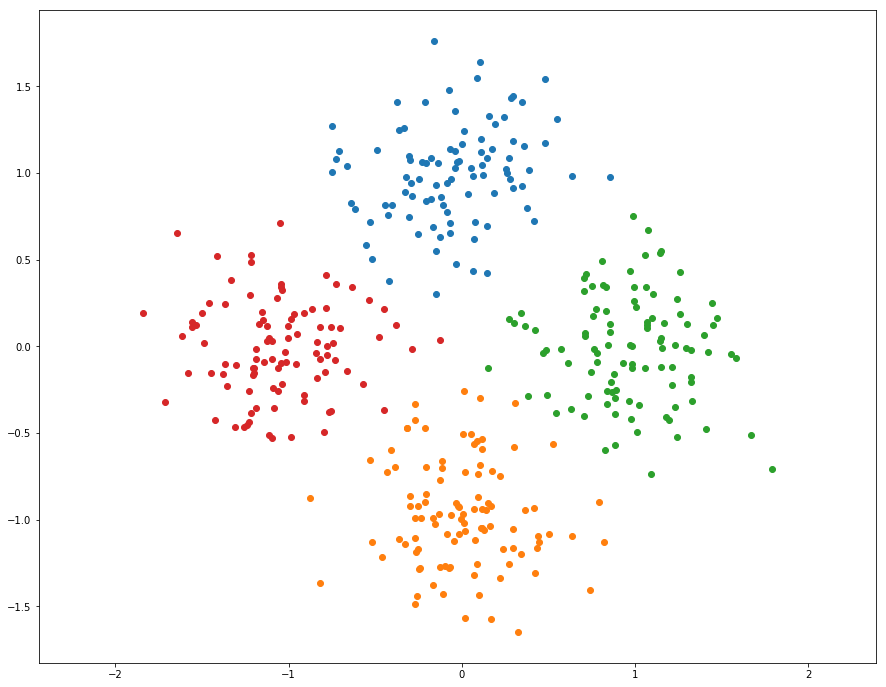

In [23]:
from segmentation import kmeans_fast

np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

**快了十六倍 ，666，向量化是个好东西！！！**

### 1.2 Hierarchical Agglomerative Clustering (20 points)
Another simple clustering algorithm is Hieararchical Agglomerative Clustering, which is somtimes abbreviated as HAC. In this algorithm, each point is initially assigned to its own cluster. Then cluster pairs are merged until we are left with the desired number of predetermined clusters (see Algorithm 1).

Implement **`hiererachical_clustering`** in `segmentation.py`.

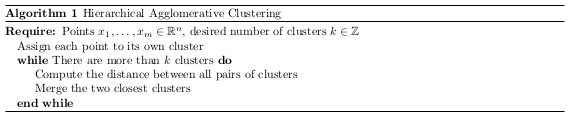

# 层次凝聚聚类

按照上图的算法定义是：
1. 初始化每个点为一个簇
2. 迭代直到只剩下K个簇：
    - 计算所有簇与簇之间（簇对）的距离
    - 合并最近的两个簇
    
这个算法的关键，主要是如何定义簇与簇之间的距离。定义有下面三种：
- 1）单链（Single-link）：不同两个聚类中离得最近的两个点之间的距离，即MIN；
- 2）全链（Complete-link）：不同两个聚类中离得最远的两个点之间的距离，即MAX；
- 3）平均链（Average-link）：不同两个聚类中所有点对距离的平均值，即AVERAGE；

题目代码中提示的做法是，利用簇中心的欧几里得距离来定义簇与簇之间的距离。

hierarchical_clustering函数将按照这个思路实现。

>** 博客推荐 **
>
>Numpy中的距离度量函数
>
>[距离度量以及python实现(一)](https://www.cnblogs.com/denny402/p/7027954.html)
>

hierarchical_clustering running time: 0.191211 seconds.


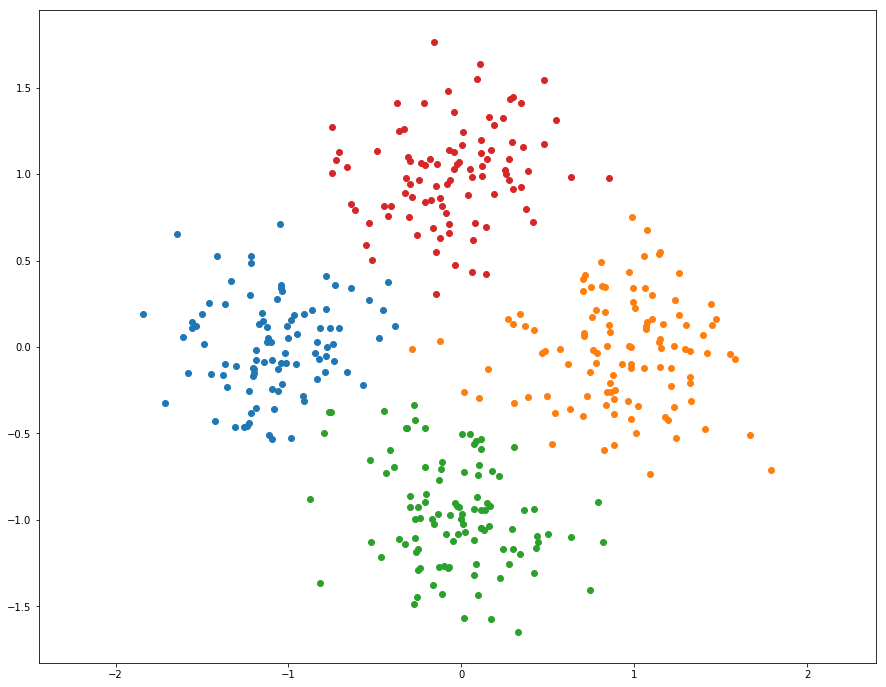

In [46]:
from segmentation import hierarchical_clustering

start = time()
assignments = hierarchical_clustering(X, 4)
end = time()

print("hierarchical_clustering running time: %f seconds." % (end - start))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

运行时间比预期的块，总结一下就是这类算法的提速方式：
- 第一个是善用向量化，用矩阵来计算问题
- 第二个就是善用numpy提供的函数，解决一些需要搜索遍历的问题

## 2 Pixel-Level Features (30 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vectore* for each pixel. The feature vector for each pixel should encode the qualities that we care about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

# 像素级特征
上一步的聚类算法实现其实是流程的第二步，第一步其实是特征的提取，有了特征才能进行像素（或者说样本）的聚类。只不过第一步中，拿了点的位置作为特征来进行聚类了。

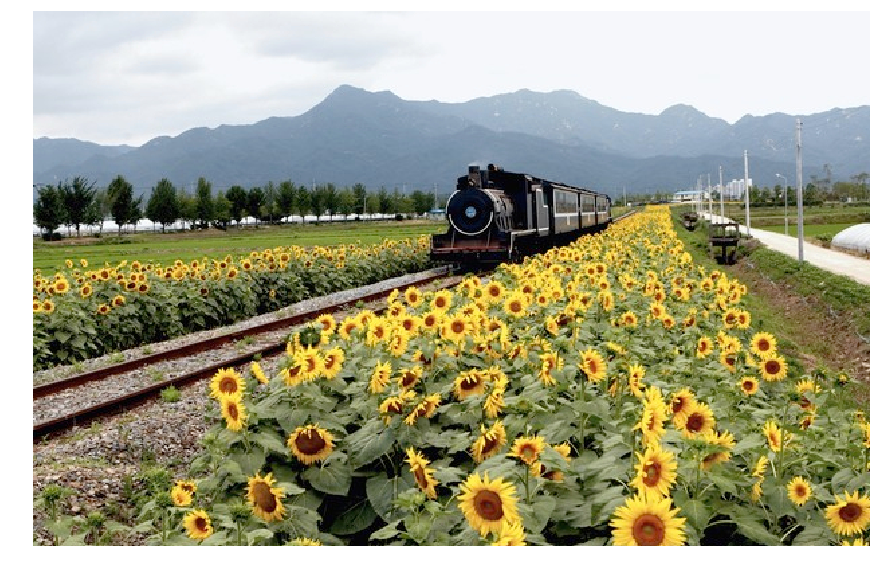

In [48]:
# Load and display image
img = io.imread('train.jpg')
H, W, C = img.shape

plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (15 points)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. Output should look like the following:
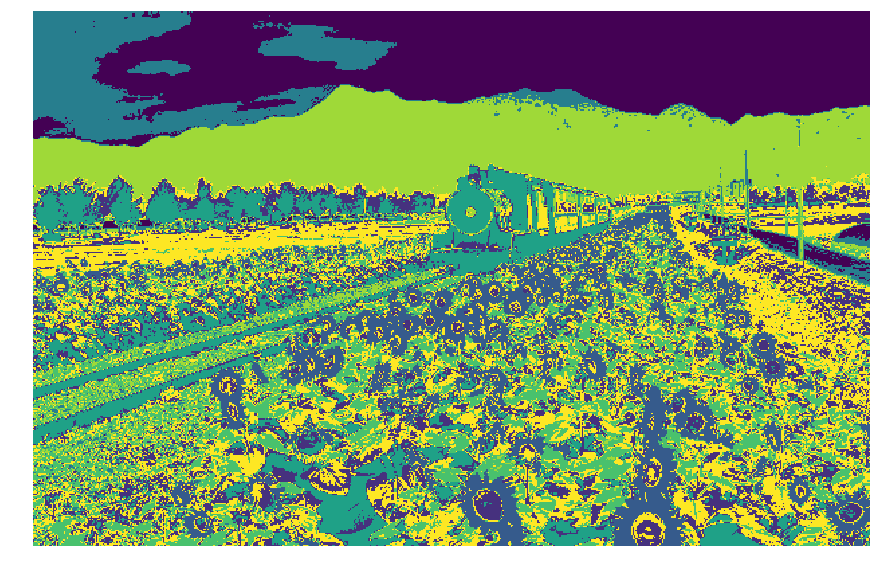

在color_features实现简单的颜色特征的聚类。

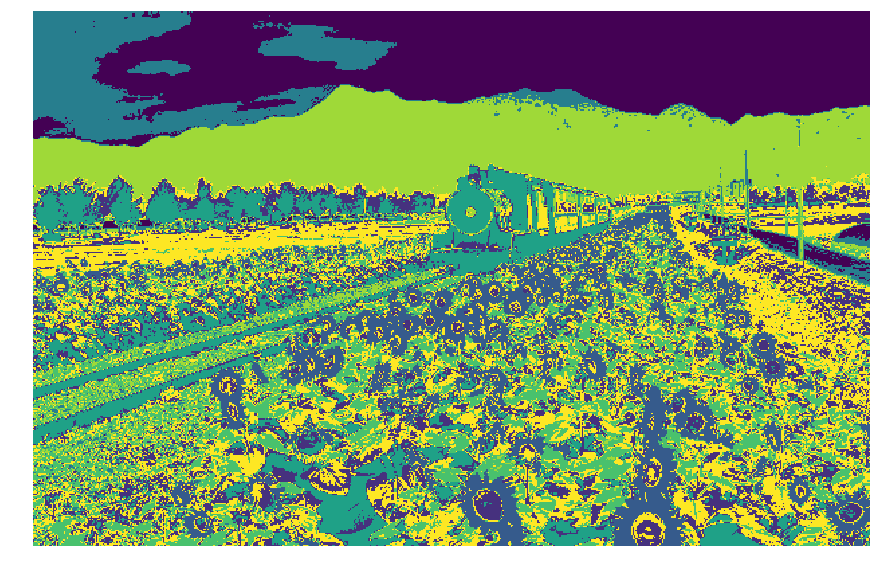

In [50]:
from segmentation import color_features
np.random.seed(0)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

将聚类结果用颜色进行显示（颜色是指源图各个分割区域内的颜色均值）

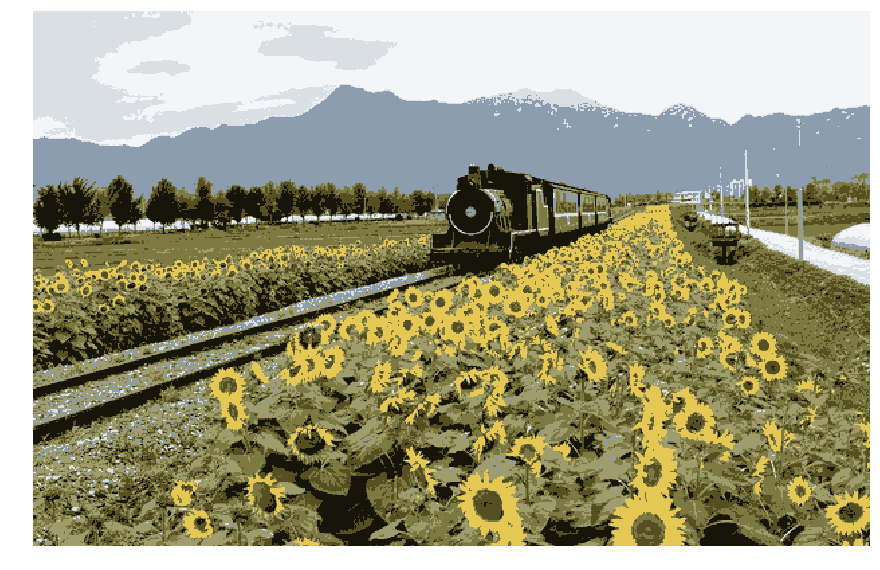

In [53]:
from utils import visualize_mean_color_image
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (15 points)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`.

Output segmentation should look like the following:
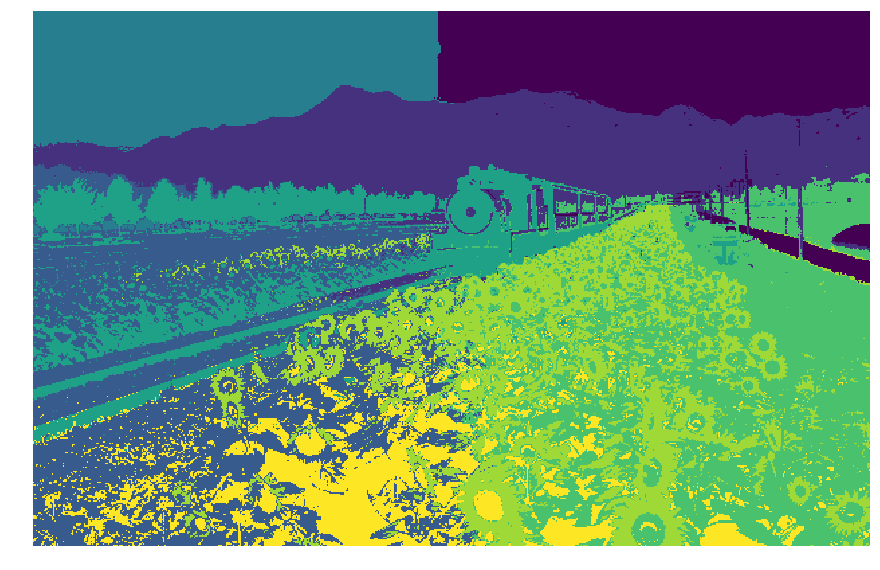

**结合颜色特征和位置特征的聚类**

其实就是生成特征为  $(r,g,b,x,y)$的序列，但需要考虑的问题是尺度的不同，解决的方案也很简单，就是进行归一化，对每一个维度进行归一化。公式如下：
$$
feature_{new} = \frac{(feature - Mean(feature))}{Std (feature)} 
$$

>**知识点补充**
>
>[Numpy中stack()，hstack()，vstack()函数详解](https://blog.csdn.net/csdn15698845876/article/details/73380803)
>

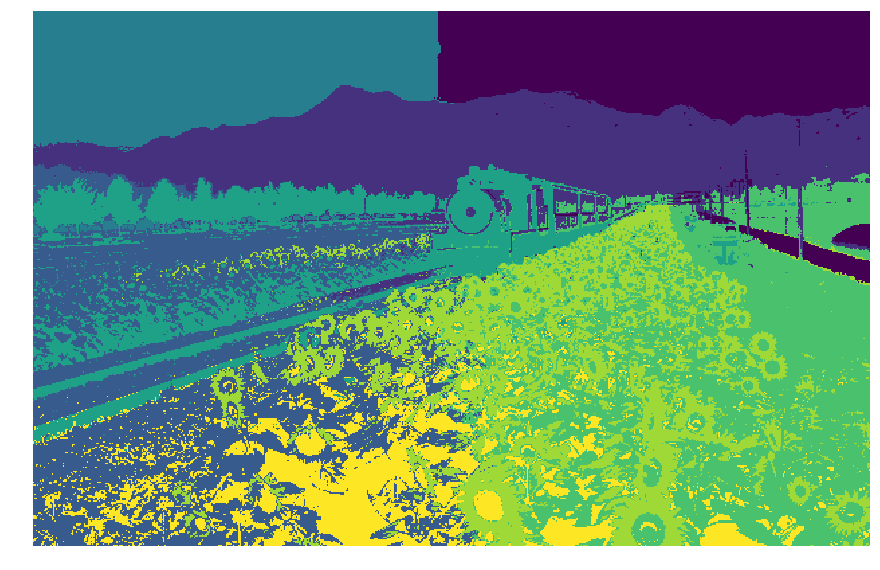

In [61]:
from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

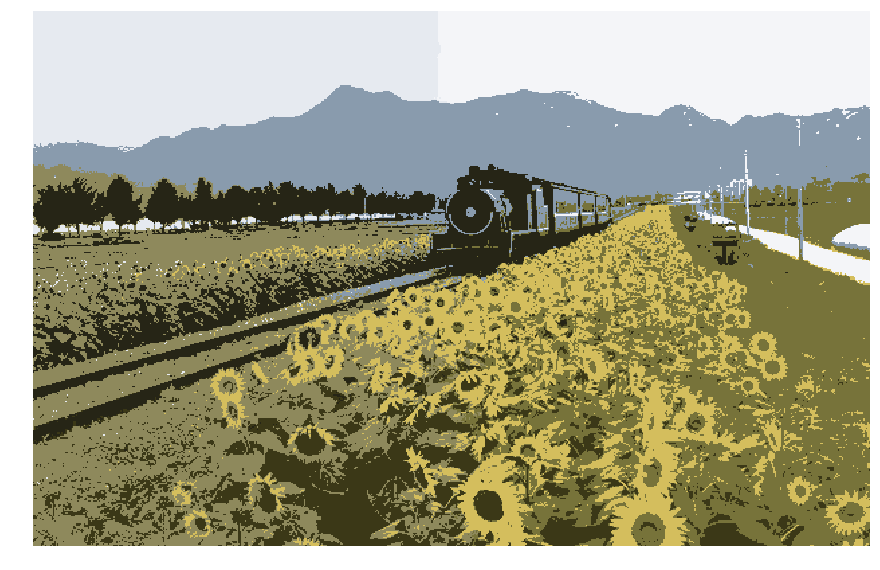

In [62]:
visualize_mean_color_image(img, segments)

### Extra Credit: Implement Your Own Feature
For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

Implement your feature extractor **`my_features`** in `segmentation.py`

Depending on the creativity of your approach and the quality of your writeup, implementing extra feature vectors can be worth extra credit (up to 5% of total points).

**Describe your approach**: (YOUR APPROACH)

**实现自己定义的特征**

可以实现一些简单的特征，比如添加梯度、边缘、SIFT描述子或者其他信息。

我添加了一个梯度强度信息，结合颜色特征，位置特征。

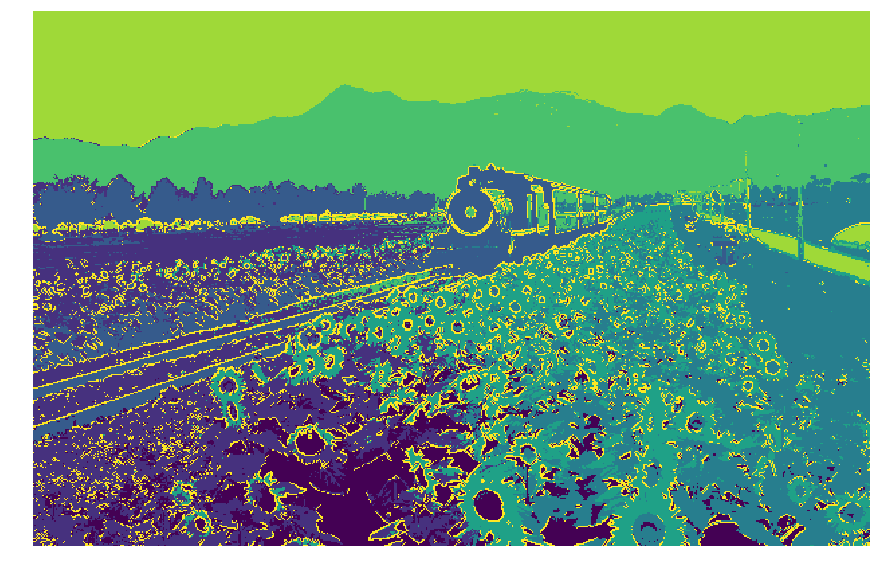

In [87]:
from segmentation import my_features

# Feel free to experiment with different images
# and varying number of segments
img = io.imread('train.jpg')
num_segments = 8

H, W, C = img.shape

# Extract pixel-level features
features = my_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

效果看上去还可以，就是后面的量化评估并没有好成绩。

## 3 Quantitative Evaluation (30 points)

Looking at images is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance.

For this project we have supplied a small dataset of cat images and ground truth segmentations of these images into foreground (cats) and background (everything else). We will quantitatively evaluate different segmentation methods (features and clustering methods) on this dataset.

We can cast the segmentation task into a binary classification problem, where we need to classify each pixel in an image into either foreground (positive) or background (negative). Given the ground-truth labels, the accuracy of a segmentation is $(TP+TN)/(P+N)$.

Implement **`compute_accuracy`** in `segmentation.py`.

实现准确率计算就是正确个数与总个数之比。

Accuracy: 0.97


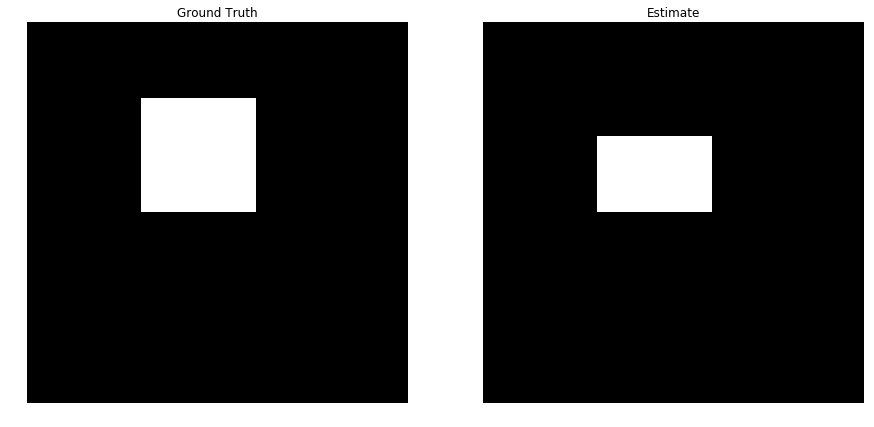

In [63]:
from segmentation import compute_accuracy

mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

You can use the script below to evaluate a segmentation method’s ability to separate foreground from background on the entire provided dataset. Use this script as a starting point to evaluate a variety of segmentation parameters.

下面这段程序是已经完成的，主要逻辑就是
1. 加载数据集，包括原图和分割结果真值
2. 调用之前实现的聚类分割算法进行分割
3. 将真值和分割结果进行比对，计算准确率

可以在下面进行调参，更改参数，查看效果。

In [89]:
from utils import load_dataset, compute_segmentation
from segmentation import evaluate_segmentation,my_features

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data')

# Set the parameters for segmentation.
num_segments = 3
clustering_fn = kmeans_fast  #hierarchical_clustering 
feature_fn = color_position_features # color_features #color_position_features # my_features
scale =0.5

mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    segments = compute_segmentation(img, num_segments,
                                    clustering_fn=clustering_fn,
                                    feature_fn=feature_fn,
                                    scale=scale)
    
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Accuracy for image 0: 0.8330
Accuracy for image 1: 0.9221
Accuracy for image 2: 0.9859
Accuracy for image 3: 0.8517
Accuracy for image 4: 0.6973
Accuracy for image 5: 0.7073
Accuracy for image 6: 0.6290
Accuracy for image 7: 0.5707
Accuracy for image 8: 0.9028
Accuracy for image 9: 0.9225
Accuracy for image 10: 0.8701
Accuracy for image 11: 0.6352
Accuracy for image 12: 0.8259
Accuracy for image 13: 0.6570
Accuracy for image 14: 0.7508
Accuracy for image 15: 0.6221
Mean accuracy: 0.7740


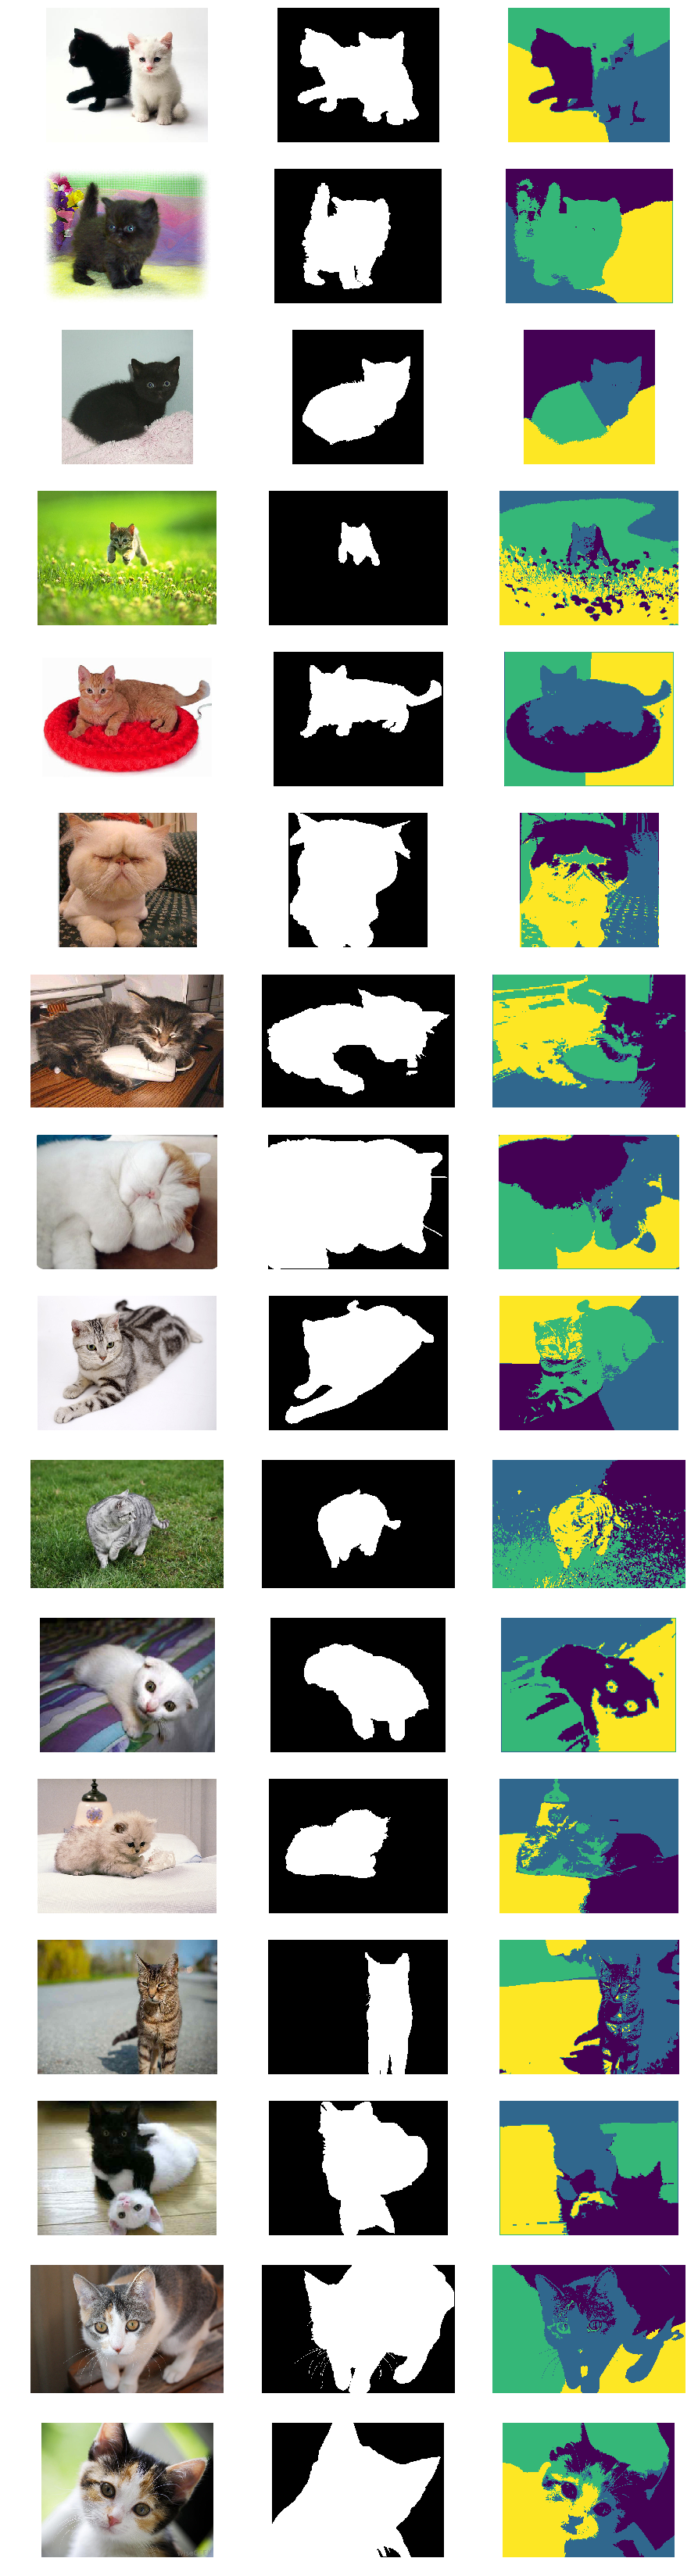

In [70]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Include a detailed evaluation of the effect of varying segmentation parameters (feature transform, clustering method, number of clusters, resize) on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 10 combinations of parameters. To present your results, add rows to the table below (you may delete the first row).

 <table style="width:100%">
  <tr>
    <th>Feature Transform</th>
    <th>Clustering Method</th>
    <th>Number of segments</th>
    <th>Scale</th>
    <th>Mean Accuracy</th>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.7979</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>4</td>
    <td>0.5</td>
    <td>0.7664</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.5</td>
    <td>0.7609</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.4</td>
    <td>0.7904</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.6</td>
    <td>0.7935</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.8</td>
    <td>0.7963</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>1</td>
    <td>0.7974</td>
  </tr>
  <tr>
    <td>Color-Postion</td>
    <td>K-Means</td>
    <td>3</td>
    <td>1</td>
    <td>0.7767</td>
  </tr>
  <tr>
    <td>Color-Postion</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.7883</td>
  </tr>
   <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
    
</table> 

Observe your results carefully and try to answer the following question:
1. Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?
2. Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?
3. Also feel free to point out or discuss any other interesting observations that you made.

Write your analysis in the cell below.

**Your answer here**:

1. 基于对结果的观察：
    1. 基于颜色-位置特征的聚类效果比基于颜色特征的聚类效果差
    2. 聚类数目3个就是最好的了，增大减小都影响效果
    3. 尺度是越接近原图，也就是越接近1，准确度越高
    
2. 的确存在一些图更难识别。这些图的一些特性包括
    1. 背景较为复杂
    2. 前景颜色、亮度都与背景较为接近
3. 我发现在基于颜色-位置特征的聚类中，尺度并不是越大越好，可能是我做的实验次数不够多。
    